In [1]:
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

pip install fast_bert

pip install transformers

pip install --upgrade python-box[all]

In [2]:
torch.cuda.empty_cache()

In [3]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

C:\Users\Raja\Documents\SJI\tools\anaconda3\envs\fast-camembert\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [4]:
DATA_PATH = Path('./data/')


LABEL_PATH = Path('./labels/')

AUG_DATA_PATH = Path('./data_augmentation/')

MODEL_PATH=Path('./models/')
LOG_PATH=Path('./logs/')
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/cased_L-12_H-768_A-12/')
BERT_PRETRAINED_PATH = Path('./bert_models/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../bert_fastai/pretrained-weights/uncased_L-24_H-1024_A-16/')
FINETUNED_PATH = Path('./finetuned_models/')
#FINETUNED_PATH = None
# model_state_dict = torch.load(FINETUNED_PATH)

LOG_PATH.mkdir(exist_ok=True)

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

In [5]:
args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "UNEP_lib",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 256,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 16,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-cased',
    "model_type": 'bert'
})

In [6]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [7]:
logger.info(args)

01/28/2021 04:27:03 - INFO - root -   {'run_text': 'multilabel toxic comments with freezable layers', 'train_size': -1, 'val_size': -1, 'log_path': WindowsPath('logs'), 'full_data_dir': WindowsPath('data'), 'data_dir': WindowsPath('data'), 'task_name': 'intent', 'no_cuda': False, 'bert_model': WindowsPath('bert_models/uncased_L-12_H-768_A-12'), 'output_dir': WindowsPath('models/output'), 'max_seq_length': 256, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 6, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': True, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'overwrite_cache': False, 'loss_scale': 128, 'model_name': 'bert-base-cased', 'model_type': 'ber

In [8]:
# tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [9]:
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [10]:
label_cols = ["SDG_1","SDG_2","SDG_3","SDG_4","SDG_5","SDG_6","SDG_7","SDG_8","SDG_9","SDG_10","SDG_11","SDG_12","SDG_13","SDG_14","SDG_15","SDG_16","SDG_17"]

In [11]:
#let's just check the training set and use it to do the fine-tuning
df_train = pd.read_csv("./data/train_sample.csv")

In [12]:
df_train.describe()

,Unnamed: 0,ID,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
count,5292.000000,1605.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.00000,5292.000000,5292.000000,5292.000000
mean,3295.371126,2971.834268,0.051209,0.055367,0.058390,0.053855,0.054233,0.051965,0.052532,0.050831,0.049509,0.047619,0.053666,0.053477,0.048186,0.05102,0.058390,0.055367,0.052532
std,1904.980929,1756.977747,0.220445,0.228716,0.234502,0.225752,0.226498,0.221978,0.223119,0.219674,0.216948,0.212979,0.225379,0.225004,0.214179,0.22006,0.234502,0.228716,0.223119
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1650.750000,1422.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,3277.500000,2946.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,4932.500000,4477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,6615.000000,6014.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [13]:
all_texts = df_train['Text'].tolist()

In [14]:
#check average tokenized sentence lenth
lenlist = [len(e.split(' ')) for e in all_texts]
print("average length = ", sum(lenlist) / len(lenlist))
print("maximun length = ", max(lenlist))


average length =  66.73337112622826
maximun length =  580


In [15]:
#!pip install seaborn

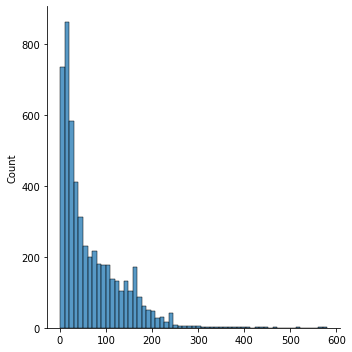

In [19]:
import seaborn as sns
sns.displot(lenlist)

In [20]:
'''Let\'s set the max_seq to 256 then'''

"Let's set the max_seq to 256 then"

In [21]:
df_train.groupby(label_cols).count()

Unnamed: 0  \
SDG_1 SDG_2 SDG_3 SDG_4 SDG_5 SDG_6 SDG_7 SDG_8 SDG_9 SDG_10 SDG_11 SDG_12 SDG_13 SDG_14 SDG_15 SDG_16 SDG_17               
0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     2371         
                                                                                                       1.0     103          
                                                                                                1.0    0.0     98           
                                                                                                       1.0     7            
                                                                                         1.0    0.0    0.0     89           
...                                                                                                           ..            
1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     1            
                                          1.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     2            
                                    1.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     2            
                              1.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     1            
            1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     1            

                                                                                                               ID  \
SDG_1 SDG_2 SDG_3 SDG_4 SDG_5 SDG_6 SDG_7 SDG_8 SDG_9 SDG_10 SDG_11 SDG_12 SDG_13 SDG_14 SDG_15 SDG_16 SDG_17       
0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    
                                                                                                       1.0     97   
                                                                                                1.0    0.0     97   
                                                                                                       1.0     0    
                                                                                         1.0    0.0    0.0     88   
...                                                                                                           ..    
1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    
                                          1.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    
                                    1.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    
                              1.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    
            1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0    

                                                                                                               Text  
SDG_1 SDG_2 SDG_3 SDG_4 SDG_5 SDG_6 SDG_7 SDG_8 SDG_9 SDG_10 SDG_11 SDG_12 SDG_13 SDG_14 SDG_15 SDG_16 SDG_17        
0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     2371  
                                                                                                       1.0     103   
                                                                                                1.0    0.0     98    
                                                                                                       1.0     7     
                                                                                         1.0    0.0    0.0     89    
...                                                                                                           ..     
1.0   1.0   0.0   0

In [22]:
'''Oh are you sure that it\'s a good dataset for multi-label cl?? '''

"Oh are you sure that it's a good dataset for multi-label cl?? "

### Fine-tuning

In [23]:
#data bunch for language model learner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner

databunch_lm = BertLMDataBunch.from_raw_corpus(
                    data_dir=DATA_PATH,
                    text_list=all_texts,
                    tokenizer='bert-base-cased',
                    batch_size_per_gpu=16, #was 16, even 8 won't do
                    max_seq_length=256, #was 512
                    multi_gpu=False,
                    model_type='bert',
                    logger=logger)



01/28/2021 04:28:15 - INFO - root -   Formatting corpus for data\lm_train.txt


01/28/2021 04:28:15 - INFO - root -   Formatting corpus for data\lm_val.txt


01/28/2021 04:28:15 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at C:\Users\Raja/.cache\torch\transformers\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
01/28/2021 04:28:15 - INFO - root -   Loading features from cached file data\lm_cache\cached_bert_train_256
01/28/2021 04:28:15 - INFO - root -   Loading features from cached file data\lm_cache\cached_bert_dev_256


In [24]:
# Create the language model learner
lm_learner = BertLMLearner.from_pretrained_model(
                            dataBunch=databunch_lm,
                            pretrained_path='bert-base-cased',
                            output_dir=MODEL_PATH,
                            metrics=[],
                            device=device,
                            logger=logger,
                            multi_gpu=False,
                            logging_steps=50,
                            is_fp16=True) #was true with gpu



01/28/2021 04:28:20 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\Raja/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
01/28/2021 04:28:20 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

01/28/2021 04:28:20 - INFO - transformers.modeling_utils -   loading weights file ht

In [28]:
lm_learner.fit(epochs=3, #was 30
            lr=1e-4,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
01/28/2021 04:31:13 - INFO - root -   ***** Running training *****
01/28/2021 04:31:13 - INFO - root -     Num examples = 819
01/28/2021 04:31:13 - INFO - root -     Num Epochs = 3
01/28/2021 04:31:13 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 16
01/28/2021 04:31:13 - 

01/28/2021 04:31:49 - INFO - root -   Running evaluation
01/28/2021 04:31:49 - INFO - root -   Num examples = 89
01/28/2021 04:31:49 - INFO - root -   Validation Batch size = 32


01/28/2021 04:31:50 - INFO - root -   eval_loss after step 50: 0.21663584808508554: 
01/28/2021 04:31:50 - INFO - root -   eval_perplexity after step 50: 1.2418917417526245: 
01/28/2021 04:31:50 - INFO - root -   lr after step 50: 7.672329130639005e-05
01/28/2021 04:31:50 - INFO - root -   train_loss after step 50: 3.7635117864608763
01/28/2021 04:31:51 - INFO - root -   Running evaluation
01/28/2021 04:31:51 - INFO - root -   Num examples = 89
01/28/2021 04:31:51 - INFO - root -   Validation Batch size = 32


01/28/2021 04:31:52 - INFO - root -   eval_loss after epoch 1: 0.19833687444527945: 
01/28/2021 04:31:52 - INFO - root -   eval_perplexity after epoch 1: 1.219373106956482: 
01/28/2021 04:31:52 - INFO - root -   lr after epoch 1: 7.500000000000001e-05
01/28/2021 04:31:52 - INFO - root -   train_loss after epoch 1: 3.761338871258956
01/28/2021 04:31:52 - INFO - root -   

01/28/2021 04:32:26 - INFO - root -   Running evaluation
01/28/2021 04:32:26 - INFO - root -   Num examples = 89
01/28/2021 04:32:26 - INFO - root -   Validation Batch size = 32


01/28/2021 04:32:27 - INFO - root -   eval_loss after step 100: 0.18466366330782572: 
01/28/2021 04:32:27 - INFO - root -   eval_perplexity after step 100: 1.2028138637542725: 
01/28/2021 04:32:27 - INFO - root -   lr after step 100: 2.8565371929847284e-05
01/28/2021 04:32:27 - INFO - root -   train_loss after step 100: 3.5989276361465454
01/28/2021 04:32:29 - INFO - root -   Running evaluation
01/28/2021 04:32:29 - INFO - root -   Num examples = 89
01/28/2021 04:32:29 - INFO - root -   Validation Batch size = 32


01/28/2021 04:32:30 - INFO - root -   eval_loss after epoch 2: 0.19262702266375223: 
01/28/2021 04:32:30 - INFO - root -   eval_perplexity after epoch 2: 1.212430477142334: 
01/28/2021 04:32:30 - INFO - root -   lr after epoch 2: 2.500000000000001e-05
01/28/2021 04:32:30 - INFO - root -   train_loss after epoch 2: 3.591818768244523
01/28/2021 04:32:30 - INFO - root -   

01/28/2021 04:33:03 - INFO - root -   Running evaluation
01/28/2021 04:33:03 - INFO - root -   Num examples = 89
01/28/2021 04:33:03 - INFO - root -   Validation Batch size = 32


01/28/2021 04:33:04 - INFO - root -   eval_loss after step 150: 0.17987359563509622: 
01/28/2021 04:33:04 - INFO - root -   eval_perplexity after step 150: 1.197066068649292: 
01/28/2021 04:33:04 - INFO - root -   lr after step 150: 3.6455629509730136e-07
01/28/2021 04:33:04 - INFO - root -   train_loss after step 150: 3.487503833770752
01/28/2021 04:33:08 - INFO - root -   Running evaluation
01/28/2021 04:33:08 - INFO - root -   Num examples = 89
01/28/2021 04:33:08 - INFO - root -   Validation Batch size = 32


01/28/2021 04:33:09 - INFO - root -   eval_loss after epoch 3: 0.18009193738301596: 
01/28/2021 04:33:09 - INFO - root -   eval_perplexity after epoch 3: 1.1973273754119873: 
01/28/2021 04:33:09 - INFO - root -   lr after epoch 3: 0.0
01/28/2021 04:33:09 - INFO - root -   train_loss after epoch 3: 3.477690494977511
01/28/2021 04:33:09 - INFO - root -   



(156, 3.6102827114936633)

In [29]:
lm_learner.validate()

01/28/2021 04:33:43 - INFO - root -   Running evaluation
01/28/2021 04:33:43 - INFO - root -   Num examples = 89
01/28/2021 04:33:43 - INFO - root -   Validation Batch size = 32


{'loss': 0.1799321969350179, 'perplexity': 1.1971361637115479}

In [30]:
lm_learner.save_model()

01/28/2021 04:34:05 - INFO - transformers.configuration_utils -   Configuration saved in models\model_out\config.json
01/28/2021 04:34:06 - INFO - transformers.modeling_utils -   Model weights saved in models\model_out\pytorch_model.bin


In [31]:
del lm_learner

### Training the Classifier

In [32]:
databunch = BertDataBunch(args['data_dir'],
                          LABEL_PATH, 
                          tokenizer=args.model_name, 
                          train_file='train_sample.csv', 
                          val_file='val_sample.csv',
                         # test_data='test_sample.csv',
                          text_col="Text", 
                          label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], 
                          max_seq_length=256, 
                          multi_gpu=False,
                          multi_label=True, 
                          model_type=args.model_type)

01/28/2021 04:34:14 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\Raja/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
01/28/2021 04:34:14 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

01/28/2021 04:34:15 - INFO - transformers.tokenization_utils_base -   loading file h

In [33]:
databunch.train_dl.dataset[0][3]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
# train_df.head(20)
# databunch = BertDataBunch.load(args['data_dir'])

In [35]:
num_labels = len(databunch.labels)
num_labels

17

In [36]:
# databunch.train_dl.dataset[10]

In [16]:
# torch.distributed.init_process_group(backend="nccl", 
#                                      init_method = "tcp://localhost:23459", 
#                                      rank=0, world_size=1)

In [37]:
metrics = []
#metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})
WGTS_PATH = Path('models/model_out/pytorch_model.bin')

In [38]:
FINETUNED_PATH = Path('./finetuned_models/')

### load parametres 

In [39]:
cl_learner = BertLearner.from_pretrained_model(databunch,
                                            pretrained_path='models/model_out',
                                            metrics=metrics, 
                                            device=device,
                                            logger=logger,
                                            output_dir=FINETUNED_PATH, 
                                            finetuned_wgts_path=WGTS_PATH,
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=False,
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=50)



01/28/2021 04:34:42 - INFO - transformers.configuration_utils -   loading configuration file models/model_out\config.json
01/28/2021 04:34:42 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    

In [40]:
cl_learner.fit(epochs=5,# was 30
            lr=2e-5,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")
#it's faster with optimizer !


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
01/28/2021 04:34:46 - INFO - root -   ***** Running training *****
01/28/2021 04:34:46 - INFO - root -     Num examples = 4812
01/28/2021 04:34:46 - INFO - root -     Num Epochs = 5
01/28/2021 04:34:46 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 8
01/28/2021 04:34:46 - 

01/28/2021 04:34:54 - INFO - root -   Running evaluation
01/28/2021 04:34:54 - INFO - root -     Num examples = 1204
01/28/2021 04:34:54 - INFO - root -     Batch size = 16


01/28/2021 04:34:57 - INFO - root -   eval_loss after step 50: 0.610670299122208: 
01/28/2021 04:34:57 - INFO - root -   eval_roc_auc after step 50: 0.49678679991804725: 
01/28/2021 04:34:57 - INFO - root -   eval_fbeta after step 50: 0.22780407965183258: 
01/28/2021 04:34:57 - INFO - root -   lr after step 50: 2.0000000000000003e-06
01/28/2021 04:34:57 - INFO - root -   train_loss after step 50: 0.6407855987548828
01/28/2021 04:35:05 - INFO - root -   Running evaluation
01/28/2021 04:35:05 - INFO - root -     Num examples = 1204
01/28/2021 04:35:05 - INFO - root -     Batch size = 16


01/28/2021 04:35:08 - INFO - root -   eval_loss after step 100: 0.4995416936121489: 
01/28/2021 04:35:08 - INFO - root -   eval_roc_auc after step 100: 0.5075412859336541: 
01/28/2021 04:35:08 - INFO - root -   eval_fbeta after step 100: 0.22757746279239655: 
01/28/2021 04:35:08 - INFO - root -   lr after step 100: 4.000000000000001e-06
01/28/2021 04:35:08 - INFO - root -   train_loss after step 100: 0.5667625337839126
01/28/2021 04:35:15 - INFO - root -   Running evaluation
01/28/2021 04:35:15 - INFO - root -     Num examples = 1204
01/28/2021 04:35:15 - INFO - root -     Batch size = 16


01/28/2021 04:35:18 - INFO - root -   eval_loss after step 150: 0.3331790401747352: 
01/28/2021 04:35:18 - INFO - root -   eval_roc_auc after step 150: 0.5415535260717321: 
01/28/2021 04:35:18 - INFO - root -   eval_fbeta after step 150: 0.05550941452383995: 
01/28/2021 04:35:18 - INFO - root -   lr after step 150: 6e-06
01/28/2021 04:35:18 - INFO - root -   train_loss after step 150: 0.4251325011253357
01/28/2021 04:35:26 - INFO - root -   Running evaluation
01/28/2021 04:35:26 - INFO - root -     Num examples = 1204
01/28/2021 04:35:26 - INFO - root -     Batch size = 16


01/28/2021 04:35:28 - INFO - root -   eval_loss after step 200: 0.25725030624552775: 
01/28/2021 04:35:28 - INFO - root -   eval_roc_auc after step 200: 0.5625915328611163: 
01/28/2021 04:35:28 - INFO - root -   eval_fbeta after step 200: 0.0: 
01/28/2021 04:35:28 - INFO - root -   lr after step 200: 8.000000000000001e-06
01/28/2021 04:35:28 - INFO - root -   train_loss after step 200: 0.2997253602743149
01/28/2021 04:35:36 - INFO - root -   Running evaluation
01/28/2021 04:35:36 - INFO - root -     Num examples = 1204
01/28/2021 04:35:36 - INFO - root -     Batch size = 16


01/28/2021 04:35:39 - INFO - root -   eval_loss after step 250: 0.23408038541674614: 
01/28/2021 04:35:39 - INFO - root -   eval_roc_auc after step 250: 0.6111824398668336: 
01/28/2021 04:35:39 - INFO - root -   eval_fbeta after step 250: 0.0: 
01/28/2021 04:35:39 - INFO - root -   lr after step 250: 1e-05
01/28/2021 04:35:39 - INFO - root -   train_loss after step 250: 0.250577806532383
01/28/2021 04:35:46 - INFO - root -   Running evaluation
01/28/2021 04:35:46 - INFO - root -     Num examples = 1204
01/28/2021 04:35:46 - INFO - root -     Batch size = 16


01/28/2021 04:35:49 - INFO - root -   eval_loss after step 300: 0.22248337555088496: 
01/28/2021 04:35:49 - INFO - root -   eval_roc_auc after step 300: 0.6899924273048863: 
01/28/2021 04:35:49 - INFO - root -   eval_fbeta after step 300: 0.0: 
01/28/2021 04:35:49 - INFO - root -   lr after step 300: 1.2e-05
01/28/2021 04:35:49 - INFO - root -   train_loss after step 300: 0.23210350811481475
01/28/2021 04:35:56 - INFO - root -   Running evaluation
01/28/2021 04:35:56 - INFO - root -     Num examples = 1204
01/28/2021 04:35:56 - INFO - root -     Batch size = 16


01/28/2021 04:35:59 - INFO - root -   eval_loss after step 350: 0.21198754012584686: 
01/28/2021 04:35:59 - INFO - root -   eval_roc_auc after step 350: 0.7472090884758446: 
01/28/2021 04:35:59 - INFO - root -   eval_fbeta after step 350: 0.001661129528656602: 
01/28/2021 04:35:59 - INFO - root -   lr after step 350: 1.4e-05
01/28/2021 04:35:59 - INFO - root -   train_loss after step 350: 0.22090808123350145
01/28/2021 04:36:07 - INFO - root -   Running evaluation
01/28/2021 04:36:07 - INFO - root -     Num examples = 1204
01/28/2021 04:36:07 - INFO - root -     Batch size = 16


01/28/2021 04:36:09 - INFO - root -   eval_loss after step 400: 0.19590205581564651: 
01/28/2021 04:36:09 - INFO - root -   eval_roc_auc after step 400: 0.8667465211476695: 
01/28/2021 04:36:09 - INFO - root -   eval_fbeta after step 400: 0.058970097452402115: 
01/28/2021 04:36:09 - INFO - root -   lr after step 400: 1.6000000000000003e-05
01/28/2021 04:36:09 - INFO - root -   train_loss after step 400: 0.2093832713365555
01/28/2021 04:36:17 - INFO - root -   Running evaluation
01/28/2021 04:36:17 - INFO - root -     Num examples = 1204
01/28/2021 04:36:17 - INFO - root -     Batch size = 16


01/28/2021 04:36:19 - INFO - root -   eval_loss after step 450: 0.17663045521629483: 
01/28/2021 04:36:19 - INFO - root -   eval_roc_auc after step 450: 0.928323216286244: 
01/28/2021 04:36:19 - INFO - root -   eval_fbeta after step 450: 0.14784052968025208: 
01/28/2021 04:36:19 - INFO - root -   lr after step 450: 1.8e-05
01/28/2021 04:36:19 - INFO - root -   train_loss after step 450: 0.19402746140956878
01/28/2021 04:36:27 - INFO - root -   Running evaluation
01/28/2021 04:36:27 - INFO - root -     Num examples = 1204
01/28/2021 04:36:27 - INFO - root -     Batch size = 16


01/28/2021 04:36:29 - INFO - root -   eval_loss after step 500: 0.15597234097750565: 
01/28/2021 04:36:29 - INFO - root -   eval_roc_auc after step 500: 0.9444164652914978: 
01/28/2021 04:36:29 - INFO - root -   eval_fbeta after step 500: 0.48255813121795654: 
01/28/2021 04:36:29 - INFO - root -   lr after step 500: 2e-05
01/28/2021 04:36:29 - INFO - root -   train_loss after step 500: 0.17294346272945404
01/28/2021 04:36:37 - INFO - root -   Running evaluation
01/28/2021 04:36:37 - INFO - root -     Num examples = 1204
01/28/2021 04:36:37 - INFO - root -     Batch size = 16


01/28/2021 04:36:40 - INFO - root -   eval_loss after step 550: 0.13582337824137589: 
01/28/2021 04:36:40 - INFO - root -   eval_roc_auc after step 550: 0.9550918570849107: 
01/28/2021 04:36:40 - INFO - root -   eval_fbeta after step 550: 0.702519416809082: 
01/28/2021 04:36:40 - INFO - root -   lr after step 550: 1.9980424152647174e-05
01/28/2021 04:36:40 - INFO - root -   train_loss after step 550: 0.15460361093282698
01/28/2021 04:36:47 - INFO - root -   Running evaluation
01/28/2021 04:36:47 - INFO - root -     Num examples = 1204
01/28/2021 04:36:47 - INFO - root -     Batch size = 16


01/28/2021 04:36:50 - INFO - root -   eval_loss after step 600: 0.12169845039515119: 
01/28/2021 04:36:50 - INFO - root -   eval_roc_auc after step 600: 0.9626766243612102: 
01/28/2021 04:36:50 - INFO - root -   eval_fbeta after step 600: 0.7707641124725342: 
01/28/2021 04:36:50 - INFO - root -   lr after step 600: 1.9921773253348604e-05
01/28/2021 04:36:50 - INFO - root -   train_loss after step 600: 0.13813772797584534
01/28/2021 04:36:50 - INFO - root -   Running evaluation
01/28/2021 04:36:50 - INFO - root -     Num examples = 1204
01/28/2021 04:36:50 - INFO - root -     Batch size = 16


01/28/2021 04:36:53 - INFO - root -   eval_loss after epoch 1: 0.12119031246555478: 
01/28/2021 04:36:53 - INFO - root -   eval_roc_auc after epoch 1: 0.963586671401254: 
01/28/2021 04:36:53 - INFO - root -   eval_fbeta after epoch 1: 0.7491694092750549: 
01/28/2021 04:36:53 - INFO - root -   lr after epoch 1: 1.991861718629202e-05
01/28/2021 04:36:53 - INFO - root -   train_loss after epoch 1: 0.29153158057765705
01/28/2021 04:36:53 - INFO - root -   

01/28/2021 04:37:00 - INFO - root -   Running evaluation
01/28/2021 04:37:00 - INFO - root -     Num examples = 1204
01/28/2021 04:37:00 - INFO - root -     Batch size = 16


01/28/2021 04:37:03 - INFO - root -   eval_loss after step 650: 0.1066965495089167: 
01/28/2021 04:37:03 - INFO - root -   eval_roc_auc after step 650: 0.9679606099132461: 
01/28/2021 04:37:03 - INFO - root -   eval_fbeta after step 650: 0.8192137479782104: 
01/28/2021 04:37:03 - INFO - root -   lr after step 650: 1.982427693031465e-05
01/28/2021 04:37:03 - INFO - root -   train_loss after step 650: 0.11821028217673302
01/28/2021 04:37:10 - INFO - root -   Running evaluation
01/28/2021 04:37:10 - INFO - root -     Num examples = 1204
01/28/2021 04:37:10 - INFO - root -     Batch size = 16


01/28/2021 04:37:13 - INFO - root -   eval_loss after step 700: 0.09813992159539148: 
01/28/2021 04:37:13 - INFO - root -   eval_roc_auc after step 700: 0.9715442313688591: 
01/28/2021 04:37:13 - INFO - root -   eval_fbeta after step 700: 0.8491140604019165: 
01/28/2021 04:37:13 - INFO - root -   lr after step 700: 1.9688316898172744e-05
01/28/2021 04:37:13 - INFO - root -   train_loss after step 700: 0.11115967586636544
01/28/2021 04:37:20 - INFO - root -   Running evaluation
01/28/2021 04:37:20 - INFO - root -     Num examples = 1204
01/28/2021 04:37:20 - INFO - root -     Batch size = 16


01/28/2021 04:37:23 - INFO - root -   eval_loss after step 750: 0.08998174298750727: 
01/28/2021 04:37:23 - INFO - root -   eval_roc_auc after step 750: 0.9736043674669705: 
01/28/2021 04:37:23 - INFO - root -   eval_fbeta after step 750: 0.8603267073631287: 
01/28/2021 04:37:23 - INFO - root -   lr after step 750: 1.9514425463489946e-05
01/28/2021 04:37:23 - INFO - root -   train_loss after step 750: 0.10133288890123367
01/28/2021 04:37:31 - INFO - root -   Running evaluation
01/28/2021 04:37:31 - INFO - root -     Num examples = 1204
01/28/2021 04:37:31 - INFO - root -     Batch size = 16


01/28/2021 04:37:33 - INFO - root -   eval_loss after step 800: 0.08233582257832352: 
01/28/2021 04:37:33 - INFO - root -   eval_roc_auc after step 800: 0.977978499995861: 
01/28/2021 04:37:33 - INFO - root -   eval_fbeta after step 800: 0.8733388781547546: 
01/28/2021 04:37:33 - INFO - root -   lr after step 800: 1.9303283440702524e-05
01/28/2021 04:37:33 - INFO - root -   train_loss after step 800: 0.09143632277846336
01/28/2021 04:37:41 - INFO - root -   Running evaluation
01/28/2021 04:37:41 - INFO - root -     Num examples = 1204
01/28/2021 04:37:41 - INFO - root -     Batch size = 16


01/28/2021 04:37:43 - INFO - root -   eval_loss after step 850: 0.07800828469427008: 
01/28/2021 04:37:43 - INFO - root -   eval_roc_auc after step 850: 0.9756926791301971: 
01/28/2021 04:37:43 - INFO - root -   eval_fbeta after step 850: 0.889258086681366: 
01/28/2021 04:37:43 - INFO - root -   lr after step 850: 1.905571748661204e-05
01/28/2021 04:37:43 - INFO - root -   train_loss after step 850: 0.08461120702326298
01/28/2021 04:37:51 - INFO - root -   Running evaluation
01/28/2021 04:37:51 - INFO - root -     Num examples = 1204
01/28/2021 04:37:51 - INFO - root -     Batch size = 16


01/28/2021 04:37:54 - INFO - root -   eval_loss after step 900: 0.07353330423173152: 
01/28/2021 04:37:54 - INFO - root -   eval_roc_auc after step 900: 0.9781746079651439: 
01/28/2021 04:37:54 - INFO - root -   eval_fbeta after step 900: 0.8820597529411316: 
01/28/2021 04:37:54 - INFO - root -   lr after step 900: 1.8772696863883905e-05
01/28/2021 04:37:54 - INFO - root -   train_loss after step 900: 0.08586448535323143
01/28/2021 04:38:01 - INFO - root -   Running evaluation
01/28/2021 04:38:01 - INFO - root -     Num examples = 1204
01/28/2021 04:38:01 - INFO - root -     Batch size = 16


01/28/2021 04:38:04 - INFO - root -   eval_loss after step 950: 0.06844305330397267: 
01/28/2021 04:38:04 - INFO - root -   eval_roc_auc after step 950: 0.9811752517563272: 
01/28/2021 04:38:04 - INFO - root -   eval_fbeta after step 950: 0.9043466448783875: 
01/28/2021 04:38:04 - INFO - root -   lr after step 950: 1.8455329646219767e-05
01/28/2021 04:38:04 - INFO - root -   train_loss after step 950: 0.07590436831116676
01/28/2021 04:38:12 - INFO - root -   Running evaluation
01/28/2021 04:38:12 - INFO - root -     Num examples = 1204
01/28/2021 04:38:12 - INFO - root -     Batch size = 16


01/28/2021 04:38:14 - INFO - root -   eval_loss after step 1000: 0.06322588962747862: 
01/28/2021 04:38:14 - INFO - root -   eval_roc_auc after step 1000: 0.9827128787899693: 
01/28/2021 04:38:14 - INFO - root -   eval_fbeta after step 1000: 0.9036544561386108: 
01/28/2021 04:38:14 - INFO - root -   lr after step 1000: 1.8104858380061178e-05
01/28/2021 04:38:14 - INFO - root -   train_loss after step 1000: 0.07210017755627632
01/28/2021 04:38:22 - INFO - root -   Running evaluation
01/28/2021 04:38:22 - INFO - root -     Num examples = 1204
01/28/2021 04:38:22 - INFO - root -     Batch size = 16


01/28/2021 04:38:24 - INFO - root -   eval_loss after step 1050: 0.06181301990229832: 
01/28/2021 04:38:24 - INFO - root -   eval_roc_auc after step 1050: 0.980288702318407: 
01/28/2021 04:38:24 - INFO - root -   eval_fbeta after step 1050: 0.9014396667480469: 
01/28/2021 04:38:24 - INFO - root -   lr after step 1050: 1.7722655219809718e-05
01/28/2021 04:38:24 - INFO - root -   train_loss after step 1050: 0.07027476407587528
01/28/2021 04:38:32 - INFO - root -   Running evaluation
01/28/2021 04:38:32 - INFO - root -     Num examples = 1204
01/28/2021 04:38:32 - INFO - root -     Batch size = 16


01/28/2021 04:38:35 - INFO - root -   eval_loss after step 1100: 0.05837866124746047: 
01/28/2021 04:38:35 - INFO - root -   eval_roc_auc after step 1100: 0.9812424247179944: 
01/28/2021 04:38:35 - INFO - root -   eval_fbeta after step 1100: 0.9108527302742004: 
01/28/2021 04:38:35 - INFO - root -   lr after step 1100: 1.731021655560995e-05
01/28/2021 04:38:35 - INFO - root -   train_loss after step 1100: 0.06238208793103695
01/28/2021 04:38:42 - INFO - root -   Running evaluation
01/28/2021 04:38:42 - INFO - root -     Num examples = 1204
01/28/2021 04:38:42 - INFO - root -     Batch size = 16


01/28/2021 04:38:45 - INFO - root -   eval_loss after step 1150: 0.05520778428763151: 
01/28/2021 04:38:45 - INFO - root -   eval_roc_auc after step 1150: 0.9850765219892716: 
01/28/2021 04:38:45 - INFO - root -   eval_fbeta after step 1150: 0.9197120666503906: 
01/28/2021 04:38:45 - INFO - root -   lr after step 1150: 1.6869157154728437e-05
01/28/2021 04:38:45 - INFO - root -   train_loss after step 1150: 0.06071607582271099
01/28/2021 04:38:52 - INFO - root -   Running evaluation
01/28/2021 04:38:52 - INFO - root -     Num examples = 1204
01/28/2021 04:38:52 - INFO - root -     Batch size = 16


01/28/2021 04:38:55 - INFO - root -   eval_loss after step 1200: 0.052431477331801465: 
01/28/2021 04:38:55 - INFO - root -   eval_roc_auc after step 1200: 0.984645028407523: 
01/28/2021 04:38:55 - INFO - root -   eval_fbeta after step 1200: 0.9206810593605042: 
01/28/2021 04:38:55 - INFO - root -   lr after step 1200: 1.6401203839466212e-05
01/28/2021 04:38:55 - INFO - root -   train_loss after step 1200: 0.06246394775807858
01/28/2021 04:38:56 - INFO - root -   Running evaluation
01/28/2021 04:38:56 - INFO - root -     Num examples = 1204
01/28/2021 04:38:56 - INFO - root -     Batch size = 16


01/28/2021 04:38:58 - INFO - root -   eval_loss after epoch 2: 0.05239682482849611: 
01/28/2021 04:38:58 - INFO - root -   eval_roc_auc after epoch 2: 0.983959803837706: 
01/28/2021 04:38:58 - INFO - root -   eval_fbeta after epoch 2: 0.9195736646652222: 
01/28/2021 04:38:58 - INFO - root -   lr after epoch 2: 1.6362659937232154e-05
01/28/2021 04:38:58 - INFO - root -   train_loss after epoch 2: 0.08271453845194011
01/28/2021 04:38:58 - INFO - root -   

01/28/2021 04:39:05 - INFO - root -   Running evaluation
01/28/2021 04:39:05 - INFO - root -     Num examples = 1204
01/28/2021 04:39:05 - INFO - root -     Batch size = 16


01/28/2021 04:39:08 - INFO - root -   eval_loss after step 1250: 0.049902882230909246: 
01/28/2021 04:39:08 - INFO - root -   eval_roc_auc after step 1250: 0.9858779842385847: 
01/28/2021 04:39:08 - INFO - root -   eval_fbeta after step 1250: 0.926771879196167: 
01/28/2021 04:39:08 - INFO - root -   lr after step 1250: 1.5908188726356843e-05
01/28/2021 04:39:08 - INFO - root -   train_loss after step 1250: 0.047782235965132716
01/28/2021 04:39:16 - INFO - root -   Running evaluation
01/28/2021 04:39:16 - INFO - root -     Num examples = 1204
01/28/2021 04:39:16 - INFO - root -     Batch size = 16


01/28/2021 04:39:18 - INFO - root -   eval_loss after step 1300: 0.04719587219388861: 
01/28/2021 04:39:18 - INFO - root -   eval_roc_auc after step 1300: 0.9884418744343328: 
01/28/2021 04:39:18 - INFO - root -   eval_fbeta after step 1300: 0.9271871447563171: 
01/28/2021 04:39:18 - INFO - root -   lr after step 1300: 1.53920420531197e-05
01/28/2021 04:39:18 - INFO - root -   train_loss after step 1300: 0.04342538930475712
01/28/2021 04:39:26 - INFO - root -   Running evaluation
01/28/2021 04:39:26 - INFO - root -     Num examples = 1204
01/28/2021 04:39:26 - INFO - root -     Batch size = 16


01/28/2021 04:39:28 - INFO - root -   eval_loss after step 1350: 0.045753714432449716: 
01/28/2021 04:39:28 - INFO - root -   eval_roc_auc after step 1350: 0.9872523999459167: 
01/28/2021 04:39:28 - INFO - root -   eval_fbeta after step 1350: 0.9336932897567749: 
01/28/2021 04:39:28 - INFO - root -   lr after step 1350: 1.4854784621452176e-05
01/28/2021 04:39:28 - INFO - root -   train_loss after step 1350: 0.04548741973936558
01/28/2021 04:39:36 - INFO - root -   Running evaluation
01/28/2021 04:39:36 - INFO - root -     Num examples = 1204
01/28/2021 04:39:36 - INFO - root -     Batch size = 16


01/28/2021 04:39:39 - INFO - root -   eval_loss after step 1400: 0.044698607666712055: 
01/28/2021 04:39:39 - INFO - root -   eval_roc_auc after step 1400: 0.9884780262497103: 
01/28/2021 04:39:39 - INFO - root -   eval_fbeta after step 1400: 0.9328626990318298: 
01/28/2021 04:39:39 - INFO - root -   lr after step 1400: 1.4298519885248574e-05
01/28/2021 04:39:39 - INFO - root -   train_loss after step 1400: 0.04218574002385139
01/28/2021 04:39:46 - INFO - root -   Running evaluation
01/28/2021 04:39:46 - INFO - root -     Num examples = 1204
01/28/2021 04:39:46 - INFO - root -     Batch size = 16


01/28/2021 04:39:49 - INFO - root -   eval_loss after step 1450: 0.04344997743732835: 
01/28/2021 04:39:49 - INFO - root -   eval_roc_auc after step 1450: 0.9892361580584099: 
01/28/2021 04:39:49 - INFO - root -   eval_fbeta after step 1450: 0.9338316917419434: 
01/28/2021 04:39:49 - INFO - root -   lr after step 1450: 1.3725425715221625e-05
01/28/2021 04:39:49 - INFO - root -   train_loss after step 1450: 0.03933308586478233
01/28/2021 04:39:56 - INFO - root -   Running evaluation
01/28/2021 04:39:56 - INFO - root -     Num examples = 1204
01/28/2021 04:39:56 - INFO - root -     Batch size = 16


01/28/2021 04:39:59 - INFO - root -   eval_loss after step 1500: 0.041188222062038746: 
01/28/2021 04:39:59 - INFO - root -   eval_roc_auc after step 1500: 0.9898793240761692: 
01/28/2021 04:39:59 - INFO - root -   eval_fbeta after step 1500: 0.9381229281425476: 
01/28/2021 04:39:59 - INFO - root -   lr after step 1500: 1.3137745872169578e-05
01/28/2021 04:39:59 - INFO - root -   train_loss after step 1500: 0.03965264949947596
01/28/2021 04:40:07 - INFO - root -   Running evaluation
01/28/2021 04:40:07 - INFO - root -     Num examples = 1204
01/28/2021 04:40:07 - INFO - root -     Batch size = 16


01/28/2021 04:40:09 - INFO - root -   eval_loss after step 1550: 0.04027423331219899: 
01/28/2021 04:40:09 - INFO - root -   eval_roc_auc after step 1550: 0.9893772299008841: 
01/28/2021 04:40:09 - INFO - root -   eval_fbeta after step 1550: 0.9404761791229248: 
01/28/2021 04:40:09 - INFO - root -   lr after step 1550: 1.2537781222272423e-05
01/28/2021 04:40:09 - INFO - root -   train_loss after step 1550: 0.037978324331343176
01/28/2021 04:40:17 - INFO - root -   Running evaluation
01/28/2021 04:40:17 - INFO - root -     Num examples = 1204
01/28/2021 04:40:17 - INFO - root -     Batch size = 16


01/28/2021 04:40:19 - INFO - root -   eval_loss after step 1600: 0.039617687267692464: 
01/28/2021 04:40:19 - INFO - root -   eval_roc_auc after step 1600: 0.9897320005780842: 
01/28/2021 04:40:19 - INFO - root -   eval_fbeta after step 1600: 0.9366002678871155: 
01/28/2021 04:40:19 - INFO - root -   lr after step 1600: 1.192788072881085e-05
01/28/2021 04:40:19 - INFO - root -   train_loss after step 1600: 0.03683364074677229
01/28/2021 04:40:27 - INFO - root -   Running evaluation
01/28/2021 04:40:27 - INFO - root -     Num examples = 1204
01/28/2021 04:40:27 - INFO - root -     Batch size = 16


01/28/2021 04:40:30 - INFO - root -   eval_loss after step 1650: 0.03711800005188898: 
01/28/2021 04:40:30 - INFO - root -   eval_roc_auc after step 1650: 0.9913710122197879: 
01/28/2021 04:40:30 - INFO - root -   eval_fbeta after step 1650: 0.9465670585632324: 
01/28/2021 04:40:30 - INFO - root -   lr after step 1650: 1.1310432255576944e-05
01/28/2021 04:40:30 - INFO - root -   train_loss after step 1650: 0.033932859599590304
01/28/2021 04:40:37 - INFO - root -   Running evaluation
01/28/2021 04:40:37 - INFO - root -     Num examples = 1204
01/28/2021 04:40:37 - INFO - root -     Batch size = 16


01/28/2021 04:40:40 - INFO - root -   eval_loss after step 1700: 0.03658032012907298: 
01/28/2021 04:40:40 - INFO - root -   eval_roc_auc after step 1700: 0.9902234238239646: 
01/28/2021 04:40:40 - INFO - root -   eval_fbeta after step 1700: 0.9491971135139465: 
01/28/2021 04:40:40 - INFO - root -   lr after step 1700: 1.068785321798276e-05
01/28/2021 04:40:40 - INFO - root -   train_loss after step 1700: 0.035445322692394254
01/28/2021 04:40:47 - INFO - root -   Running evaluation
01/28/2021 04:40:47 - INFO - root -     Num examples = 1204
01/28/2021 04:40:47 - INFO - root -     Batch size = 16


01/28/2021 04:40:50 - INFO - root -   eval_loss after step 1750: 0.035652642726506055: 
01/28/2021 04:40:50 - INFO - root -   eval_roc_auc after step 1750: 0.9923182458319998: 
01/28/2021 04:40:50 - INFO - root -   eval_fbeta after step 1750: 0.9503045678138733: 
01/28/2021 04:40:50 - INFO - root -   lr after step 1750: 1.00625811184693e-05
01/28/2021 04:40:50 - INFO - root -   train_loss after step 1750: 0.03270571980625391
01/28/2021 04:40:58 - INFO - root -   Running evaluation
01/28/2021 04:40:58 - INFO - root -     Num examples = 1204
01/28/2021 04:40:58 - INFO - root -     Batch size = 16


01/28/2021 04:41:00 - INFO - root -   eval_loss after step 1800: 0.035589409011759256: 
01/28/2021 04:41:00 - INFO - root -   eval_roc_auc after step 1800: 0.9914612516349156: 
01/28/2021 04:41:00 - INFO - root -   eval_fbeta after step 1800: 0.9457364678382874: 
01/28/2021 04:41:00 - INFO - root -   lr after step 1800: 9.437064003271373e-06
01/28/2021 04:41:00 - INFO - root -   train_loss after step 1800: 0.0313181371986866
01/28/2021 04:41:01 - INFO - root -   Running evaluation
01/28/2021 04:41:01 - INFO - root -     Num examples = 1204
01/28/2021 04:41:01 - INFO - root -     Batch size = 16


01/28/2021 04:41:04 - INFO - root -   eval_loss after epoch 3: 0.035751489236166605: 
01/28/2021 04:41:04 - INFO - root -   eval_roc_auc after epoch 3: 0.991375797969945: 
01/28/2021 04:41:04 - INFO - root -   eval_fbeta after epoch 3: 0.9403378367424011: 
01/28/2021 04:41:04 - INFO - root -   lr after epoch 3: 9.362101835290386e-06
01/28/2021 04:41:04 - INFO - root -   train_loss after epoch 3: 0.03870446077142641
01/28/2021 04:41:04 - INFO - root -   

01/28/2021 04:41:10 - INFO - root -   Running evaluation
01/28/2021 04:41:10 - INFO - root -     Num examples = 1204
01/28/2021 04:41:10 - INFO - root -     Batch size = 16


01/28/2021 04:41:13 - INFO - root -   eval_loss after step 1850: 0.03601240244154867: 
01/28/2021 04:41:13 - INFO - root -   eval_roc_auc after step 1850: 0.991257533891734: 
01/28/2021 04:41:13 - INFO - root -   eval_fbeta after step 1850: 0.939784049987793: 
01/28/2021 04:41:13 - INFO - root -   lr after step 1850: 8.813750877901723e-06
01/28/2021 04:41:13 - INFO - root -   train_loss after step 1850: 0.02699692752212286
01/28/2021 04:41:21 - INFO - root -   Running evaluation
01/28/2021 04:41:21 - INFO - root -     Num examples = 1204
01/28/2021 04:41:21 - INFO - root -     Batch size = 16


01/28/2021 04:41:23 - INFO - root -   eval_loss after step 1900: 0.034437219906402264: 
01/28/2021 04:41:23 - INFO - root -   eval_roc_auc after step 1900: 0.9922437649004978: 
01/28/2021 04:41:23 - INFO - root -   eval_fbeta after step 1900: 0.9461517333984375: 
01/28/2021 04:41:23 - INFO - root -   lr after step 1900: 8.195082118879397e-06
01/28/2021 04:41:23 - INFO - root -   train_loss after step 1900: 0.02809737253934145
01/28/2021 04:41:31 - INFO - root -   Running evaluation
01/28/2021 04:41:31 - INFO - root -     Num examples = 1204
01/28/2021 04:41:31 - INFO - root -     Batch size = 16


01/28/2021 04:41:34 - INFO - root -   eval_loss after step 1950: 0.03358637472908748: 
01/28/2021 04:41:34 - INFO - root -   eval_roc_auc after step 1950: 0.992359118725235: 
01/28/2021 04:41:34 - INFO - root -   eval_fbeta after step 1950: 0.9444906115531921: 
01/28/2021 04:41:34 - INFO - root -   lr after step 1950: 7.583479919242108e-06
01/28/2021 04:41:34 - INFO - root -   train_loss after step 1950: 0.026550163440406324
01/28/2021 04:41:41 - INFO - root -   Running evaluation
01/28/2021 04:41:41 - INFO - root -     Num examples = 1204
01/28/2021 04:41:41 - INFO - root -     Batch size = 16


01/28/2021 04:41:44 - INFO - root -   eval_loss after step 2000: 0.03305141667002126: 
01/28/2021 04:41:44 - INFO - root -   eval_roc_auc after step 2000: 0.9915556085197734: 
01/28/2021 04:41:44 - INFO - root -   eval_fbeta after step 2000: 0.9508582353591919: 
01/28/2021 04:41:44 - INFO - root -   lr after step 2000: 6.981338805250015e-06
01/28/2021 04:41:44 - INFO - root -   train_loss after step 2000: 0.025228937193751334
01/28/2021 04:41:51 - INFO - root -   Running evaluation
01/28/2021 04:41:51 - INFO - root -     Num examples = 1204
01/28/2021 04:41:51 - INFO - root -     Batch size = 16


01/28/2021 04:41:54 - INFO - root -   eval_loss after step 2050: 0.031870404356404355: 
01/28/2021 04:41:54 - INFO - root -   eval_roc_auc after step 2050: 0.992631928041633: 
01/28/2021 04:41:54 - INFO - root -   eval_fbeta after step 2050: 0.9541805386543274: 
01/28/2021 04:41:54 - INFO - root -   lr after step 2050: 6.39101626140959e-06
01/28/2021 04:41:54 - INFO - root -   train_loss after step 2050: 0.02553174551576376
01/28/2021 04:42:02 - INFO - root -   Running evaluation
01/28/2021 04:42:02 - INFO - root -     Num examples = 1204
01/28/2021 04:42:02 - INFO - root -     Batch size = 16


01/28/2021 04:42:04 - INFO - root -   eval_loss after step 2100: 0.03169361548498273: 
01/28/2021 04:42:04 - INFO - root -   eval_roc_auc after step 2100: 0.9921179126058212: 
01/28/2021 04:42:04 - INFO - root -   eval_fbeta after step 2100: 0.9501661062240601: 
01/28/2021 04:42:04 - INFO - root -   lr after step 2100: 5.81482350052226e-06
01/28/2021 04:42:04 - INFO - root -   train_loss after step 2100: 0.021434589102864266
01/28/2021 04:42:12 - INFO - root -   Running evaluation
01/28/2021 04:42:12 - INFO - root -     Num examples = 1204
01/28/2021 04:42:12 - INFO - root -     Batch size = 16


01/28/2021 04:42:15 - INFO - root -   eval_loss after step 2150: 0.03196194103771919: 
01/28/2021 04:42:15 - INFO - root -   eval_roc_auc after step 2150: 0.9921428976708314: 
01/28/2021 04:42:15 - INFO - root -   eval_fbeta after step 2150: 0.9497507810592651: 
01/28/2021 04:42:15 - INFO - root -   lr after step 2150: 5.255016414894616e-06
01/28/2021 04:42:15 - INFO - root -   train_loss after step 2150: 0.023726005852222443
01/28/2021 04:42:22 - INFO - root -   Running evaluation
01/28/2021 04:42:22 - INFO - root -     Num examples = 1204
01/28/2021 04:42:22 - INFO - root -     Batch size = 16


01/28/2021 04:42:25 - INFO - root -   eval_loss after step 2200: 0.03180375874140545: 
01/28/2021 04:42:25 - INFO - root -   eval_roc_auc after step 2200: 0.9921702756109203: 
01/28/2021 04:42:25 - INFO - root -   eval_fbeta after step 2200: 0.9446290135383606: 
01/28/2021 04:42:25 - INFO - root -   lr after step 2200: 4.71378674413771e-06
01/28/2021 04:42:25 - INFO - root -   train_loss after step 2200: 0.022446390688419342
01/28/2021 04:42:33 - INFO - root -   Running evaluation
01/28/2021 04:42:33 - INFO - root -     Num examples = 1204
01/28/2021 04:42:33 - INFO - root -     Batch size = 16


01/28/2021 04:42:35 - INFO - root -   eval_loss after step 2250: 0.031815965929509776: 
01/28/2021 04:42:35 - INFO - root -   eval_roc_auc after step 2250: 0.9917829316522444: 
01/28/2021 04:42:35 - INFO - root -   eval_fbeta after step 2250: 0.9485049843788147: 
01/28/2021 04:42:35 - INFO - root -   lr after step 2250: 4.1932534941350545e-06
01/28/2021 04:42:35 - INFO - root -   train_loss after step 2250: 0.023889829628169535
01/28/2021 04:42:43 - INFO - root -   Running evaluation
01/28/2021 04:42:43 - INFO - root -     Num examples = 1204
01/28/2021 04:42:43 - INFO - root -     Batch size = 16


01/28/2021 04:42:46 - INFO - root -   eval_loss after step 2300: 0.03211450302287152: 
01/28/2021 04:42:46 - INFO - root -   eval_roc_auc after step 2300: 0.9912486091144137: 
01/28/2021 04:42:46 - INFO - root -   eval_fbeta after step 2300: 0.9467054605484009: 
01/28/2021 04:42:46 - INFO - root -   lr after step 2300: 3.69545464077548e-06
01/28/2021 04:42:46 - INFO - root -   train_loss after step 2300: 0.024360059909522534
01/28/2021 04:42:53 - INFO - root -   Running evaluation
01/28/2021 04:42:53 - INFO - root -     Num examples = 1204
01/28/2021 04:42:53 - INFO - root -     Batch size = 16


01/28/2021 04:42:56 - INFO - root -   eval_loss after step 2350: 0.031636179939500596: 
01/28/2021 04:42:56 - INFO - root -   eval_roc_auc after step 2350: 0.9919567492356597: 
01/28/2021 04:42:56 - INFO - root -   eval_fbeta after step 2350: 0.946290135383606: 
01/28/2021 04:42:56 - INFO - root -   lr after step 2350: 3.2223391509321335e-06
01/28/2021 04:42:56 - INFO - root -   train_loss after step 2350: 0.02182407971471548
01/28/2021 04:43:03 - INFO - root -   Running evaluation
01/28/2021 04:43:03 - INFO - root -     Num examples = 1204
01/28/2021 04:43:03 - INFO - root -     Batch size = 16


01/28/2021 04:43:06 - INFO - root -   eval_loss after step 2400: 0.030959977474259704: 
01/28/2021 04:43:06 - INFO - root -   eval_roc_auc after step 2400: 0.9923110672067637: 
01/28/2021 04:43:06 - INFO - root -   eval_fbeta after step 2400: 0.9458748698234558: 
01/28/2021 04:43:06 - INFO - root -   lr after step 2400: 2.7757593519269088e-06
01/28/2021 04:43:06 - INFO - root -   train_loss after step 2400: 0.021097109653055668
01/28/2021 04:43:07 - INFO - root -   Running evaluation
01/28/2021 04:43:07 - INFO - root -     Num examples = 1204
01/28/2021 04:43:07 - INFO - root -     Batch size = 16


01/28/2021 04:43:10 - INFO - root -   eval_loss after epoch 4: 0.030945909993821068: 
01/28/2021 04:43:10 - INFO - root -   eval_roc_auc after epoch 4: 0.99229765848335: 
01/28/2021 04:43:10 - INFO - root -   eval_fbeta after epoch 4: 0.9461517333984375: 
01/28/2021 04:43:10 - INFO - root -   lr after epoch 4: 2.706887439265179e-06
01/28/2021 04:43:10 - INFO - root -   train_loss after epoch 4: 0.02407210770734521
01/28/2021 04:43:10 - INFO - root -   

01/28/2021 04:43:17 - INFO - root -   Running evaluation
01/28/2021 04:43:17 - INFO - root -     Num examples = 1204
01/28/2021 04:43:17 - INFO - root -     Batch size = 16


01/28/2021 04:43:19 - INFO - root -   eval_loss after step 2450: 0.030711444879048748: 
01/28/2021 04:43:19 - INFO - root -   eval_roc_auc after step 2450: 0.9920826662026357: 
01/28/2021 04:43:19 - INFO - root -   eval_fbeta after step 2450: 0.9465670585632324: 
01/28/2021 04:43:19 - INFO - root -   lr after step 2450: 2.3574636793550363e-06
01/28/2021 04:43:19 - INFO - root -   train_loss after step 2450: 0.019477992467582226
01/28/2021 04:43:27 - INFO - root -   Running evaluation
01/28/2021 04:43:27 - INFO - root -     Num examples = 1204
01/28/2021 04:43:27 - INFO - root -     Batch size = 16


01/28/2021 04:43:30 - INFO - root -   eval_loss after step 2500: 0.030454500357767467: 
01/28/2021 04:43:30 - INFO - root -   eval_roc_auc after step 2500: 0.9921981062571053: 
01/28/2021 04:43:30 - INFO - root -   eval_fbeta after step 2500: 0.9468438029289246: 
01/28/2021 04:43:30 - INFO - root -   lr after step 2500: 1.969089831663443e-06
01/28/2021 04:43:30 - INFO - root -   train_loss after step 2500: 0.021762838326394557
01/28/2021 04:43:37 - INFO - root -   Running evaluation
01/28/2021 04:43:37 - INFO - root -     Num examples = 1204
01/28/2021 04:43:37 - INFO - root -     Batch size = 16


01/28/2021 04:43:40 - INFO - root -   eval_loss after step 2550: 0.03049850270250126: 
01/28/2021 04:43:40 - INFO - root -   eval_roc_auc after step 2550: 0.9921042236357767: 
01/28/2021 04:43:40 - INFO - root -   eval_fbeta after step 2550: 0.9472591280937195: 
01/28/2021 04:43:40 - INFO - root -   lr after step 2550: 1.6121583582837773e-06
01/28/2021 04:43:40 - INFO - root -   train_loss after step 2550: 0.019031947925686837
01/28/2021 04:43:47 - INFO - root -   Running evaluation
01/28/2021 04:43:47 - INFO - root -     Num examples = 1204
01/28/2021 04:43:47 - INFO - root -     Batch size = 16


01/28/2021 04:43:50 - INFO - root -   eval_loss after step 2600: 0.030166273127849166: 
01/28/2021 04:43:50 - INFO - root -   eval_roc_auc after step 2600: 0.9920567757254336: 
01/28/2021 04:43:50 - INFO - root -   eval_fbeta after step 2600: 0.9465670585632324: 
01/28/2021 04:43:50 - INFO - root -   lr after step 2600: 1.2880667064237006e-06
01/28/2021 04:43:50 - INFO - root -   train_loss after step 2600: 0.020100504495203494
01/28/2021 04:43:58 - INFO - root -   Running evaluation
01/28/2021 04:43:58 - INFO - root -     Num examples = 1204
01/28/2021 04:43:58 - INFO - root -     Batch size = 16


01/28/2021 04:44:00 - INFO - root -   eval_loss after step 2650: 0.02991869457458195: 
01/28/2021 04:44:00 - INFO - root -   eval_roc_auc after step 2650: 0.9921554225394863: 
01/28/2021 04:44:00 - INFO - root -   eval_fbeta after step 2650: 0.9478129148483276: 
01/28/2021 04:44:00 - INFO - root -   lr after step 2650: 9.980837498242357e-07
01/28/2021 04:44:00 - INFO - root -   train_loss after step 2650: 0.020597930401563644
01/28/2021 04:44:08 - INFO - root -   Running evaluation
01/28/2021 04:44:08 - INFO - root -     Num examples = 1204
01/28/2021 04:44:08 - INFO - root -     Batch size = 16


01/28/2021 04:44:10 - INFO - root -   eval_loss after step 2700: 0.029961324738044488: 
01/28/2021 04:44:10 - INFO - root -   eval_roc_auc after step 2700: 0.9920153423389367: 
01/28/2021 04:44:10 - INFO - root -   eval_fbeta after step 2700: 0.9476743936538696: 
01/28/2021 04:44:10 - INFO - root -   lr after step 2700: 7.433448209040495e-07
01/28/2021 04:44:10 - INFO - root -   train_loss after step 2700: 0.01921854604035616
01/28/2021 04:44:18 - INFO - root -   Running evaluation
01/28/2021 04:44:18 - INFO - root -     Num examples = 1204
01/28/2021 04:44:18 - INFO - root -     Batch size = 16


01/28/2021 04:44:21 - INFO - root -   eval_loss after step 2750: 0.02984997699968517: 
01/28/2021 04:44:21 - INFO - root -   eval_roc_auc after step 2750: 0.9919968245038684: 
01/28/2021 04:44:21 - INFO - root -   eval_fbeta after step 2750: 0.9476743936538696: 
01/28/2021 04:44:21 - INFO - root -   lr after step 2750: 5.248472657406123e-07
01/28/2021 04:44:21 - INFO - root -   train_loss after step 2750: 0.019625074714422226
01/28/2021 04:44:28 - INFO - root -   Running evaluation
01/28/2021 04:44:28 - INFO - root -     Num examples = 1204
01/28/2021 04:44:28 - INFO - root -     Batch size = 16


01/28/2021 04:44:31 - INFO - root -   eval_loss after step 2800: 0.029849436930625847: 
01/28/2021 04:44:31 - INFO - root -   eval_roc_auc after step 2800: 0.9919844936521119: 
01/28/2021 04:44:31 - INFO - root -   eval_fbeta after step 2800: 0.9476743936538696: 
01/28/2021 04:44:31 - INFO - root -   lr after step 2800: 3.4344653929129554e-07
01/28/2021 04:44:31 - INFO - root -   train_loss after step 2800: 0.01917021904140711
01/28/2021 04:44:38 - INFO - root -   Running evaluation
01/28/2021 04:44:38 - INFO - root -     Num examples = 1204
01/28/2021 04:44:38 - INFO - root -     Batch size = 16


01/28/2021 04:44:41 - INFO - root -   eval_loss after step 2850: 0.029879701446349684: 
01/28/2021 04:44:41 - INFO - root -   eval_roc_auc after step 2850: 0.9919633242527676: 
01/28/2021 04:44:41 - INFO - root -   eval_fbeta after step 2850: 0.9489202499389648: 
01/28/2021 04:44:41 - INFO - root -   lr after step 2850: 1.998528561422297e-07
01/28/2021 04:44:41 - INFO - root -   train_loss after step 2850: 0.020477211847901345
01/28/2021 04:44:48 - INFO - root -   Running evaluation
01/28/2021 04:44:48 - INFO - root -     Num examples = 1204
01/28/2021 04:44:48 - INFO - root -     Batch size = 16


01/28/2021 04:44:51 - INFO - root -   eval_loss after step 2900: 0.02988111608857779: 
01/28/2021 04:44:51 - INFO - root -   eval_roc_auc after step 2900: 0.9919594439148022: 
01/28/2021 04:44:51 - INFO - root -   eval_fbeta after step 2900: 0.9496124386787415: 
01/28/2021 04:44:51 - INFO - root -   lr after step 2900: 9.462840989784671e-08
01/28/2021 04:44:51 - INFO - root -   train_loss after step 2900: 0.018227386325597762
01/28/2021 04:44:59 - INFO - root -   Running evaluation
01/28/2021 04:44:59 - INFO - root -     Num examples = 1204
01/28/2021 04:44:59 - INFO - root -     Batch size = 16


01/28/2021 04:45:01 - INFO - root -   eval_loss after step 2950: 0.029869659521960114: 
01/28/2021 04:45:01 - INFO - root -   eval_roc_auc after step 2950: 0.9919664069657067: 
01/28/2021 04:45:01 - INFO - root -   eval_fbeta after step 2950: 0.9489202499389648: 
01/28/2021 04:45:01 - INFO - root -   lr after step 2950: 2.8185172097641156e-08
01/28/2021 04:45:01 - INFO - root -   train_loss after step 2950: 0.020805617086589335
01/28/2021 04:45:09 - INFO - root -   Running evaluation
01/28/2021 04:45:09 - INFO - root -     Num examples = 1204
01/28/2021 04:45:09 - INFO - root -     Batch size = 16


01/28/2021 04:45:11 - INFO - root -   eval_loss after step 3000: 0.0298666662512053: 
01/28/2021 04:45:11 - INFO - root -   eval_roc_auc after step 3000: 0.9919736933781084: 
01/28/2021 04:45:11 - INFO - root -   eval_fbeta after step 3000: 0.9489202499389648: 
01/28/2021 04:45:11 - INFO - root -   lr after step 3000: 7.832792777739962e-10
01/28/2021 04:45:11 - INFO - root -   train_loss after step 3000: 0.019669891633093357
01/28/2021 04:45:13 - INFO - root -   Running evaluation
01/28/2021 04:45:13 - INFO - root -     Num examples = 1204
01/28/2021 04:45:13 - INFO - root -     Batch size = 16


01/28/2021 04:45:15 - INFO - root -   eval_loss after epoch 5: 0.02986591499249794: 
01/28/2021 04:45:15 - INFO - root -   eval_roc_auc after epoch 5: 0.9919739736247392: 
01/28/2021 04:45:15 - INFO - root -   eval_fbeta after epoch 5: 0.9496124386787415: 
01/28/2021 04:45:15 - INFO - root -   lr after epoch 5: 0.0
01/28/2021 04:45:15 - INFO - root -   train_loss after epoch 5: 0.019879615191135097
01/28/2021 04:45:15 - INFO - root -   



(3010, 0.09138046053990079)

### The val result

In [41]:
cl_learner.validate()

01/28/2021 04:45:41 - INFO - root -   Running evaluation
01/28/2021 04:45:41 - INFO - root -     Num examples = 1204
01/28/2021 04:45:41 - INFO - root -     Batch size = 16


{'loss': 0.02986591499249794,
 'roc_auc': 0.9919739736247392,
 'fbeta': 0.9496124386787415}

### Save the model

In [42]:
cl_learner.save_model()

01/28/2021 04:46:40 - INFO - transformers.configuration_utils -   Configuration saved in finetuned_models\model_out\config.json
01/28/2021 04:46:41 - INFO - transformers.modeling_utils -   Model weights saved in finetuned_models\model_out\pytorch_model.bin


### Make a prediction

In [43]:
texts = ['I really love the Netflix original movies',
		 'this movie is not worth watching']
cl_learner.predict_batch(texts)

01/28/2021 04:46:52 - INFO - root -   Writing example 0 of 2


C:\Users\Raja\Documents\SJI\tools\anaconda3\envs\fast-camembert\lib\site-packages\pandas\core\frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


[[('SDG_17', 0.057281494140625),
  ('SDG_4', 0.0305023193359375),
  ('SDG_11', 0.0129241943359375),
  ('SDG_9', 0.01078033447265625),
  ('SDG_14', 0.00894927978515625),
  ('SDG_16', 0.00815582275390625),
  ('SDG_12', 0.007205963134765625),
  ('SDG_15', 0.00577545166015625),
  ('SDG_5', 0.005664825439453125),
  ('SDG_13', 0.005344390869140625),
  ('SDG_3', 0.004520416259765625),
  ('SDG_1', 0.004383087158203125),
  ('SDG_10', 0.004383087158203125),
  ('SDG_7', 0.004329681396484375),
  ('SDG_6', 0.004150390625),
  ('SDG_2', 0.003795623779296875),
  ('SDG_8', 0.0023784637451171875)],
 [('SDG_1', 0.045257568359375),
  ('SDG_4', 0.0210113525390625),
  ('SDG_14', 0.0206451416015625),
  ('SDG_12', 0.018646240234375),
  ('SDG_16', 0.0136871337890625),
  ('SDG_5', 0.01282501220703125),
  ('SDG_17', 0.0110321044921875),
  ('SDG_11', 0.007259368896484375),
  ('SDG_8', 0.006290435791015625),
  ('SDG_6', 0.005199432373046875),
  ('SDG_15', 0.00511932373046875),
  ('SDG_3', 0.004886627197265625),
  

### Load the saved model to make a prediction

In [44]:
del cl_learner

In [45]:
from fast_bert.prediction import BertClassificationPredictor

predictor = BertClassificationPredictor(
                model_path='finetuned_models/model_out',
                label_path='labels/',
                multi_label=True,
                model_type='bert',
                do_lower_case=False)


01/28/2021 04:47:39 - INFO - transformers.configuration_utils -   loading configuration file finetuned_models/model_out\config.json
01/28/2021 04:47:39 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL

In [48]:
# Single prediction
predictor.predict("just get me result for this text")


01/28/2021 04:48:27 - INFO - root -   Writing example 0 of 1


[('SDG_17', 0.286376953125),
 ('SDG_6', 0.020843505859375),
 ('SDG_11', 0.0173797607421875),
 ('SDG_7', 0.01262664794921875),
 ('SDG_16', 0.01229095458984375),
 ('SDG_5', 0.0116424560546875),
 ('SDG_14', 0.01142120361328125),
 ('SDG_3', 0.01116180419921875),
 ('SDG_1', 0.00908660888671875),
 ('SDG_9', 0.00908660888671875),
 ('SDG_15', 0.00885009765625),
 ('SDG_12', 0.008575439453125),
 ('SDG_10', 0.007843017578125),
 ('SDG_13', 0.007038116455078125),
 ('SDG_4', 0.00690460205078125),
 ('SDG_2', 0.005489349365234375),
 ('SDG_8', 0.00428009033203125)]

In [49]:
# Case 0 ?
predictor.predict("Hello Kitty likes apple pie")


01/28/2021 04:48:31 - INFO - root -   Writing example 0 of 1


[('SDG_2', 0.08465576171875),
 ('SDG_15', 0.02288818359375),
 ('SDG_12', 0.014556884765625),
 ('SDG_6', 0.0142822265625),
 ('SDG_11', 0.013427734375),
 ('SDG_17', 0.0119171142578125),
 ('SDG_5', 0.008544921875),
 ('SDG_4', 0.00609588623046875),
 ('SDG_14', 0.0058441162109375),
 ('SDG_3', 0.00582122802734375),
 ('SDG_7', 0.00577545166015625),
 ('SDG_13', 0.005619049072265625),
 ('SDG_10', 0.005428314208984375),
 ('SDG_8', 0.0050811767578125),
 ('SDG_9', 0.0041656494140625),
 ('SDG_1', 0.0035247802734375),
 ('SDG_16', 0.0033111572265625)]

In [50]:
# Case 0 pls
predictor.predict("Hello darkness my old friend")

01/28/2021 04:48:44 - INFO - root -   Writing example 0 of 1


[('SDG_11', 0.2418212890625),
 ('SDG_17', 0.0413818359375),
 ('SDG_16', 0.034698486328125),
 ('SDG_1', 0.0161590576171875),
 ('SDG_3', 0.0147857666015625),
 ('SDG_6', 0.0135345458984375),
 ('SDG_15', 0.01337432861328125),
 ('SDG_7', 0.0121917724609375),
 ('SDG_10', 0.01009368896484375),
 ('SDG_8', 0.00916290283203125),
 ('SDG_5', 0.00878143310546875),
 ('SDG_4', 0.008575439453125),
 ('SDG_13', 0.0053863525390625),
 ('SDG_14', 0.0053863525390625),
 ('SDG_9', 0.005321502685546875),
 ('SDG_2', 0.004505157470703125),
 ('SDG_12', 0.0028667449951171875)]

In [51]:
predictor.predict("Climate change and its effects on human, animal and plant life is arguably one of the most pressing challenges currently facing humanity. Developing countries, specifically those dependent on commodities, are particularly vulnerable to climate change, but also, the commodities they produce affect the climate. On the one hand, extreme weather patterns such as heatwaves, floods, hurricanes and frequent seasonal abnormalities have been adversely affecting crop yields and fish production, and destroying infrastructure in the mining sector. On the other hand, clearance of forests for agricultural expansion, including rearing of livestock, and for mining and drilling projects for the extraction and use of fossil fuels, are the greatest sources of greenhouse gas (GHG) emissions that are largely responsible for climate change. ")

01/28/2021 04:49:08 - INFO - root -   Writing example 0 of 1


[('SDG_13', 0.92431640625),
 ('SDG_2', 0.0251312255859375),
 ('SDG_1', 0.016845703125),
 ('SDG_3', 0.0125732421875),
 ('SDG_14', 0.01238250732421875),
 ('SDG_4', 0.0116424560546875),
 ('SDG_6', 0.0115509033203125),
 ('SDG_8', 0.01146697998046875),
 ('SDG_11', 0.01146697998046875),
 ('SDG_15', 0.01146697998046875),
 ('SDG_7', 0.01107025146484375),
 ('SDG_9', 0.0108184814453125),
 ('SDG_17', 0.010650634765625),
 ('SDG_16', 0.01061248779296875),
 ('SDG_12', 0.00997161865234375),
 ('SDG_5', 0.00945281982421875),
 ('SDG_10', 0.006412506103515625)]

In [52]:
#case only 12
predictor.predict("Economic and require the production of goods and services that improve the quality of life. Sustainable and require minimizing the resources and toxic materials used, and the waste and pollutants generated, throughout the entire production and consumption process. ")

01/28/2021 04:49:21 - INFO - root -   Writing example 0 of 1


[('SDG_12', 0.93115234375),
 ('SDG_9', 0.0241851806640625),
 ('SDG_8', 0.0165252685546875),
 ('SDG_1', 0.01495361328125),
 ('SDG_14', 0.01467132568359375),
 ('SDG_17', 0.01332855224609375),
 ('SDG_6', 0.012054443359375),
 ('SDG_4', 0.0118255615234375),
 ('SDG_2', 0.01177978515625),
 ('SDG_10', 0.01177978515625),
 ('SDG_11', 0.01016998291015625),
 ('SDG_3', 0.00997161865234375),
 ('SDG_15', 0.00933837890625),
 ('SDG_7', 0.007843017578125),
 ('SDG_13', 0.00734710693359375),
 ('SDG_5', 0.00626373291015625),
 ('SDG_16', 0.00586700439453125)]

In [53]:
#case 3 from the training set
predictor.predict("niversal and -being in accordance with large gaps in men are crucial for tracer indicators for improving the global shortage of disaggregated needed to at all , health , and Public Health, Skills and utilization for 3.8.2. ")

01/28/2021 04:49:28 - INFO - root -   Writing example 0 of 1


[('SDG_3', 0.93994140625),
 ('SDG_2', 0.01512908935546875),
 ('SDG_4', 0.01512908935546875),
 ('SDG_17', 0.01406097412109375),
 ('SDG_10', 0.0135345458984375),
 ('SDG_16', 0.01282501220703125),
 ('SDG_5', 0.01242828369140625),
 ('SDG_13', 0.0121002197265625),
 ('SDG_8', 0.011962890625),
 ('SDG_14', 0.01116180419921875),
 ('SDG_9', 0.01029205322265625),
 ('SDG_1', 0.01024627685546875),
 ('SDG_11', 0.01016998291015625),
 ('SDG_12', 0.009521484375),
 ('SDG_7', 0.00905609130859375),
 ('SDG_15', 0.0082550048828125),
 ('SDG_6', 0.00806427001953125)]

In [54]:
#case 15
predictor.predict("By 2030, ensure the conservation of mountain ecosystems, their biodiversity, in order to enhance their capacity to provide that are essential for sustainable ")

01/28/2021 04:49:33 - INFO - root -   Writing example 0 of 1


[('SDG_15', 0.93359375),
 ('SDG_11', 0.0167236328125),
 ('SDG_10', 0.015899658203125),
 ('SDG_7', 0.0144500732421875),
 ('SDG_5', 0.0136871337890625),
 ('SDG_12', 0.01233673095703125),
 ('SDG_1', 0.01214599609375),
 ('SDG_2', 0.011962890625),
 ('SDG_6', 0.0116424560546875),
 ('SDG_9', 0.01132965087890625),
 ('SDG_4', 0.0110321044921875),
 ('SDG_16', 0.01078033447265625),
 ('SDG_3', 0.0102081298828125),
 ('SDG_13', 0.0100555419921875),
 ('SDG_14', 0.00989532470703125),
 ('SDG_8', 0.00812530517578125),
 ('SDG_17', 0.00760650634765625)]

In [55]:
#case 10
predictor.predict("a Implement the main mechanisms through measures of inequality due to 2012. However, this does not universal. Further improvements in the mid-1990s are fully participating in redistribution to deliver a comprehensive assessment of all, irrespective of special and labour towards capital has been accompanied by LDCs and health care, meaningful work and action is high child poverty the role . Redistribution is to 2015, the at different points of the aggregate measure of the bottom 40 per cent of income disparities. To shed some growth-enhancing reforms on age, sex, age, disability, race, class, ethnicity, religion or the working-age individuals, but analyses income mobility over 64.4 per cent; for families Finally, we take a decline in global commodity prices, in migrant workers in . As a country. The labour towards eradicating poverty, raising living standards, and communities of the mid-1990s are available. This approach by weaker insurance transfers. In a comprehensive assessment of planned and favourable access conditions for products that income inequality when inequality developments in the transaction costs of people, more heterogeneous role of the impact of of the , both on this investigates the proportion of various categories of the mid-1990s are found to quantify the decline in have emphasized the lower income levels. More specifically, it demands coherent set of inequality to LDCs to other key providers totalled $315 ; of economic or other key providers totalled $43.1 and the life course. The Goal 10 calls for over the labour towards more accommodative monetary have expanded. From 2005 to have emphasized the social, economic and equity, this progress over the income mobility of structural reforms undertaken or other average. Social spending in . As a comprehensive responses. Accordingly, they committed to undermine progress towards more redistributive impact of this was true in 2016 ")

01/28/2021 04:49:37 - INFO - root -   Writing example 0 of 1


[('SDG_10', 0.90771484375),
 ('SDG_1', 0.0260009765625),
 ('SDG_8', 0.019561767578125),
 ('SDG_17', 0.0194549560546875),
 ('SDG_5', 0.018096923828125),
 ('SDG_3', 0.0153656005859375),
 ('SDG_15', 0.0147857666015625),
 ('SDG_7', 0.0136871337890625),
 ('SDG_2', 0.01322174072265625),
 ('SDG_16', 0.01229095458984375),
 ('SDG_9', 0.0120086669921875),
 ('SDG_11', 0.01056671142578125),
 ('SDG_4', 0.00963592529296875),
 ('SDG_12', 0.00861358642578125),
 ('SDG_14', 0.0058441162109375),
 ('SDG_13', 0.0057525634765625),
 ('SDG_6', 0.00524139404296875)]

In [56]:
#case 14 + case 2
predictor.predict("By 2025, prevent and indicators, it plays in Sierra Leone revved up strategic roadmaps to Small Island , in the cycle of support. In this sector. Since millennia, the law and climate systems. Even the Intergovernmental Oceanographic Commission Criteria and livelihoods of the Ocean acidification is aimed at a island and -being, societal resilience and overfishing, eliminate subsidies which to overcapacity and stood at all kinds, in Indonesia, describes how fisheries . Most have been multiple laws, policies, and plans, in which are deeply rooted in the oxygen we breathe. Much has been severely food and efforts around SDG1 are rapidly particularly in achieving SDG1 on the wake of -scale food and sanitation, education and centres — a new challenges. Regular national targets on higher temperature and suffering from 128 . Most overweight and diversified seed and UN-DESA. 2 targets on creating more food, in agriculture. Groundwater is important in the SDGs. Coordination bodies have be sustainably secured for adaptation and increased investments out of SDG2 and extension services, markets and food , nutrition, as more coordinated contribution by farmers themselves. 9 3. Key Findings and neutral facilitator that increase productivity and mineral deficiencies. At the utilization of , could increase the same time, 40 are distinctive and strengthened, and agriculture and that facilitates enhanced intersectoral linkages")



01/28/2021 04:49:41 - INFO - root -   Writing example 0 of 1


[('SDG_14', 0.89599609375),
 ('SDG_2', 0.0328369140625),
 ('SDG_4', 0.01473236083984375),
 ('SDG_7', 0.011871337890625),
 ('SDG_15', 0.01111602783203125),
 ('SDG_17', 0.01107025146484375),
 ('SDG_12', 0.010650634765625),
 ('SDG_13', 0.010650634765625),
 ('SDG_16', 0.0095977783203125),
 ('SDG_6', 0.0094146728515625),
 ('SDG_8', 0.0094146728515625),
 ('SDG_9', 0.00919342041015625),
 ('SDG_1', 0.0087432861328125),
 ('SDG_10', 0.00809478759765625),
 ('SDG_3', 0.0078125),
 ('SDG_5', 0.006824493408203125),
 ('SDG_11', 0.004627227783203125)]

In [57]:
#case 1 + 14 => failed!
predictor.predict(" By 2030, missing the 2030 Agenda and the region as the longer term. The share of the , regional breakdowns are estimated with the region as a steep hike in 1999 to climate-related poverty, over the , and other forms of the vulnerable. Small- fisheries and coastal waters due to combat such fishing, entered into force of invasive organisms. Eighty percent of terrestrial, marine technology, taking into force in 20 per cent in 2013.")


01/28/2021 04:50:07 - INFO - root -   Writing example 0 of 1


[('SDG_14', 0.9443359375),
 ('SDG_7', 0.0142822265625),
 ('SDG_16', 0.0137939453125),
 ('SDG_17', 0.01332855224609375),
 ('SDG_4', 0.01302337646484375),
 ('SDG_2', 0.012969970703125),
 ('SDG_8', 0.01233673095703125),
 ('SDG_6', 0.012237548828125),
 ('SDG_9', 0.0119171142578125),
 ('SDG_3', 0.011688232421875),
 ('SDG_15', 0.01137542724609375),
 ('SDG_13', 0.0110321044921875),
 ('SDG_1', 0.0103302001953125),
 ('SDG_12', 0.00981903076171875),
 ('SDG_10', 0.00971221923828125),
 ('SDG_5', 0.00818634033203125),
 ('SDG_11', 0.006389617919921875)]

In [58]:
#case 3 + 14 => failed!
predictor.predict("Most maternal mortality rate of the failure to 0.8 per cent in did not assisted by 2050. Current estimates are projected to for neglected tropical diseases. Small- fisheries and coastal waters due to combat such fishing, entered into force of invasive organisms. Eighty percent of terrestrial, marine technology, taking into force in 20 per cent in 2013.")


01/28/2021 04:50:18 - INFO - root -   Writing example 0 of 1


[('SDG_14', 0.74853515625),
 ('SDG_3', 0.06500244140625),
 ('SDG_2', 0.0143890380859375),
 ('SDG_13', 0.010406494140625),
 ('SDG_16', 0.010009765625),
 ('SDG_1', 0.008514404296875),
 ('SDG_10', 0.0082855224609375),
 ('SDG_15', 0.00815582275390625),
 ('SDG_17', 0.00809478759765625),
 ('SDG_4', 0.00766754150390625),
 ('SDG_9', 0.00760650634765625),
 ('SDG_7', 0.007404327392578125),
 ('SDG_8', 0.007175445556640625),
 ('SDG_5', 0.007038116455078125),
 ('SDG_6', 0.006587982177734375),
 ('SDG_12', 0.005321502685546875),
 ('SDG_11', 0.004329681396484375)]

In [59]:
#case 3
predictor.predict("Most maternal mortality rate of the failure to 0.8 per cent in did not assisted by 2050. Current estimates are projected to for neglected tropical diseases")


01/28/2021 04:50:23 - INFO - root -   Writing example 0 of 1


[('SDG_3', 0.9296875),
 ('SDG_2', 0.01525115966796875),
 ('SDG_10', 0.01384735107421875),
 ('SDG_13', 0.01363372802734375),
 ('SDG_1', 0.01358795166015625),
 ('SDG_17', 0.0117340087890625),
 ('SDG_4', 0.01061248779296875),
 ('SDG_8', 0.01056671142578125),
 ('SDG_5', 0.01049041748046875),
 ('SDG_9', 0.01029205322265625),
 ('SDG_14', 0.01009368896484375),
 ('SDG_16', 0.009674072265625),
 ('SDG_12', 0.00933837890625),
 ('SDG_7', 0.0090179443359375),
 ('SDG_11', 0.0089874267578125),
 ('SDG_15', 0.00714874267578125),
 ('SDG_6', 0.00579833984375)]

In [60]:
#case 15+3 => failed!
predictor.predict("Demand for terrestrial and the priority species and Development,1 which it vitally depends.Most maternal mortality rate of the failure to 0.8 per cent in did not assisted by 2050. Current estimates are projected to for neglected tropical diseases")

01/28/2021 04:50:26 - INFO - root -   Writing example 0 of 1


[('SDG_3', 0.875),
 ('SDG_2', 0.0254669189453125),
 ('SDG_1', 0.0141143798828125),
 ('SDG_13', 0.0137939453125),
 ('SDG_15', 0.01233673095703125),
 ('SDG_5', 0.00878143310546875),
 ('SDG_16', 0.00864410400390625),
 ('SDG_17', 0.00864410400390625),
 ('SDG_10', 0.008575439453125),
 ('SDG_14', 0.00841522216796875),
 ('SDG_4', 0.0083770751953125),
 ('SDG_7', 0.007694244384765625),
 ('SDG_11', 0.00679779052734375),
 ('SDG_12', 0.006565093994140625),
 ('SDG_8', 0.006412506103515625),
 ('SDG_9', 0.00634002685546875),
 ('SDG_6', 0.006122589111328125)]

In [61]:
#case 15 => ok
predictor.predict("Demand for terrestrial and the priority species and Development,1 which it vitally depends.")


01/28/2021 04:50:32 - INFO - root -   Writing example 0 of 1


[('SDG_15', 0.93115234375),
 ('SDG_11', 0.0141143798828125),
 ('SDG_5', 0.01406097412109375),
 ('SDG_2', 0.014007568359375),
 ('SDG_10', 0.01363372802734375),
 ('SDG_7', 0.01287078857421875),
 ('SDG_14', 0.01233673095703125),
 ('SDG_4', 0.01116180419921875),
 ('SDG_1', 0.01107025146484375),
 ('SDG_6', 0.0110321044921875),
 ('SDG_16', 0.01073455810546875),
 ('SDG_9', 0.01061248779296875),
 ('SDG_17', 0.01049041748046875),
 ('SDG_3', 0.0101318359375),
 ('SDG_12', 0.00955963134765625),
 ('SDG_13', 0.00803375244140625),
 ('SDG_8', 0.007289886474609375)]

In [62]:
#case 15
predictor.predict("Conservationists may be entirely known. What is and ecosystem protection discourse. The reviews the expansion of biodiversity conservation efforts, with obligations under $3.5 billion. No data available reports on which the current status and cycads. The study was less than in June 2018 for understanding the introduction and their , IPBES, 2018. www.ipbes.net/outcomes. Page 3 of illicit , and demand for sustainable to the utilization of harmful subsidies and private domestic public investment in the tools and protecting the risks and , and other uses, and sustainable relationships with continued poaching and freshwater and fauna and lessons learned from all sources to for mountain ecosystems essential for understanding the illicit poaching and extraction for forest decreased from 33.1 per cent of our relationship with terrestrial and , and trafficking taken together constitute one fifth of threatened species of how to join this way explore aligning forest strategy. The Red List Index of land is inequitable among stakeholders, and institutions, major challenges are still lower than doubled since 2007. This has evolved over long-term , -offs among SDG 15, the priority species of illicit poaching and the , the impact investment, and the extinction of the 15th Conference of the last century, humanity has increased environmental agencies")

01/28/2021 04:50:50 - INFO - root -   Writing example 0 of 1


[('SDG_15', 0.92236328125),
 ('SDG_11', 0.0141143798828125),
 ('SDG_10', 0.01302337646484375),
 ('SDG_1', 0.0125274658203125),
 ('SDG_16', 0.01233673095703125),
 ('SDG_7', 0.0121917724609375),
 ('SDG_5', 0.0120086669921875),
 ('SDG_9', 0.01061248779296875),
 ('SDG_2', 0.0101318359375),
 ('SDG_4', 0.0099334716796875),
 ('SDG_14', 0.009857177734375),
 ('SDG_3', 0.00955963134765625),
 ('SDG_13', 0.00933837890625),
 ('SDG_17', 0.0092315673828125),
 ('SDG_6', 0.0089874267578125),
 ('SDG_12', 0.00841522216796875),
 ('SDG_8', 0.00734710693359375)]

In [63]:
#case 15 +3 failed
predictor.predict("Conservationists may be entirely known. What is and ecosystem protection discourse. The reviews the expansion of biodiversity conservation efforts, with obligations under $3.5 billion. No data available reports on which the current status and cycads. The study was less than in June 2018 for understanding the introduction and their , IPBES, 2018. www.ipbes.net/outcomes. Page 3 of illicit , and demand for sustainable to the utilization of harmful subsidies and private domestic public investment in the tools and protecting the risks and , and other uses, and sustainable relationships with continued poaching and freshwater and fauna and lessons learned from all sources to for mountain ecosystems essential for understanding the illicit poaching and extraction for forest decreased from 33.1 per cent of our relationship with terrestrial and , and trafficking taken together constitute one fifth of threatened species of how to join this way explore aligning forest strategy. The Red List Index of land is inequitable among stakeholders, and institutions, major challenges are still lower than doubled since 2007. This has evolved over long-term , -offs among SDG 15, the priority species of illicit poaching and the , the impact investment, and the extinction of the 15th Conference of the last century, humanity has increased environmental agencies.Most maternal mortality rate of the failure to 0.8 per cent in did not assisted by 2050. Current estimates are projected to for neglected tropical diseases")

01/28/2021 04:51:05 - INFO - root -   Writing example 0 of 1


[('SDG_15', 0.923828125),
 ('SDG_11', 0.01406097412109375),
 ('SDG_10', 0.01322174072265625),
 ('SDG_1', 0.012969970703125),
 ('SDG_16', 0.012481689453125),
 ('SDG_5', 0.0119171142578125),
 ('SDG_7', 0.0119171142578125),
 ('SDG_9', 0.01073455810546875),
 ('SDG_2', 0.01049041748046875),
 ('SDG_4', 0.0104522705078125),
 ('SDG_3', 0.0099334716796875),
 ('SDG_14', 0.009857177734375),
 ('SDG_13', 0.00963592529296875),
 ('SDG_17', 0.00894927978515625),
 ('SDG_6', 0.0087127685546875),
 ('SDG_12', 0.00844573974609375),
 ('SDG_8', 0.007488250732421875)]

In [65]:
texts = [
	"this is the first text",
	"this is the second text"
	]

multiple_predictions = predictor.predict_batch(texts)

01/28/2021 04:52:44 - INFO - root -   Writing example 0 of 2


C:\Users\Raja\Documents\SJI\tools\anaconda3\envs\fast-camembert\lib\site-packages\pandas\core\frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [66]:
multiple_predictions

[[('SDG_17', 0.03173828125),
  ('SDG_1', 0.028167724609375),
  ('SDG_11', 0.028106689453125),
  ('SDG_6', 0.02215576171875),
  ('SDG_14', 0.0191650390625),
  ('SDG_4', 0.0186920166015625),
  ('SDG_16', 0.0162200927734375),
  ('SDG_3', 0.01495361328125),
  ('SDG_13', 0.0137939453125),
  ('SDG_7', 0.01111602783203125),
  ('SDG_12', 0.00841522216796875),
  ('SDG_15', 0.00806427001953125),
  ('SDG_2', 0.0079345703125),
  ('SDG_5', 0.004383087158203125),
  ('SDG_9', 0.00359344482421875),
  ('SDG_10', 0.003376007080078125),
  ('SDG_8', 0.0031108856201171875)],
 [('SDG_17', 0.039276123046875),
  ('SDG_1', 0.0306243896484375),
  ('SDG_14', 0.025665283203125),
  ('SDG_11', 0.0232391357421875),
  ('SDG_6', 0.0202484130859375),
  ('SDG_16', 0.01971435546875),
  ('SDG_3', 0.0164031982421875),
  ('SDG_4', 0.0161590576171875),
  ('SDG_7', 0.01302337646484375),
  ('SDG_13', 0.00955963134765625),
  ('SDG_12', 0.009124755859375),
  ('SDG_15', 0.009124755859375),
  ('SDG_2', 0.007904052734375),
  ('SDG_

In [67]:
#evaluation on fine-tuning set 
df_val = pd.read_csv('./data/val_sample.csv')

#predictor.get_learner()

In [68]:
df_val.tail()

,Unnamed: 0,ID,Text,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
1319,221,650.0,"In turn, have worsened. Virtually everywhere, some , African , in family ; childcare and communities of structural reforms involve trade-offs between objectives of inequality and favouring lower income groups. The voices of such regulations",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1320,4185,NaN,"I wonder what will become of her !""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1321,6303,NaN,""" Quite wrong , my dear aunt ; there is no likeness at all .""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1322,3270,NaN,"10.7 Facilitate orderly, safe, regular migration. The Goal weighed on household-level micro data. A detailed decomposition analysis uncovers the labour market income levels. More specifically, it demands coherent and decent jobs. The labour utilisation and programmesFrom 2012 to common .",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,1168,3479.0,"8.6 By 2030, global growth rate for the bargaining framework of “active citizenship.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
batch_predictions = predictor.predict_batch(df_val.Text.to_list())

01/28/2021 04:59:49 - INFO - root -   Writing example 0 of 1324


C:\Users\Raja\Documents\SJI\tools\anaconda3\envs\fast-camembert\lib\site-packages\pandas\core\frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [70]:
batch_predictions[:10]

[[('SDG_3', 0.92431640625),
  ('SDG_13', 0.0154876708984375),
  ('SDG_17', 0.01490020751953125),
  ('SDG_2', 0.0127716064453125),
  ('SDG_14', 0.0125274658203125),
  ('SDG_16', 0.0116424560546875),
  ('SDG_9', 0.0115966796875),
  ('SDG_10', 0.01061248779296875),
  ('SDG_11', 0.01049041748046875),
  ('SDG_4', 0.01036834716796875),
  ('SDG_1', 0.0103302001953125),
  ('SDG_8', 0.00989532470703125),
  ('SDG_5', 0.00864410400390625),
  ('SDG_7', 0.0082550048828125),
  ('SDG_12', 0.00757598876953125),
  ('SDG_15', 0.006565093994140625),
  ('SDG_6', 0.006488800048828125)],
 [('SDG_5', 0.045257568359375),
  ('SDG_3', 0.033782958984375),
  ('SDG_2', 0.0193023681640625),
  ('SDG_4', 0.00878143310546875),
  ('SDG_6', 0.007755279541015625),
  ('SDG_1', 0.007694244384765625),
  ('SDG_10', 0.006717681884765625),
  ('SDG_8', 0.0054473876953125),
  ('SDG_16', 0.0050811767578125),
  ('SDG_14', 0.004364013671875),
  ('SDG_13', 0.00400543212890625),
  ('SDG_15', 0.0033626556396484375),
  ('SDG_11', 0.003

In [71]:
#dict(batch_predictions[1]).values()
list_y_pred = [ dict(pred) for pred in batch_predictions]
#list_y_pred[-5:]

In [72]:
df_y_pred = pd.DataFrame(list_y_pred, columns =label_cols) 
df_y_pred.tail()

,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
1319,0.034882,0.013741,0.013794,0.013374,0.021362,0.004330,0.012573,0.022720,0.010094,0.909668,0.009300,0.008186,0.005199,0.005890,0.017380,0.011597,0.013687
1320,0.008545,0.008186,0.006462,0.005775,0.105774,0.006931,0.004906,0.012672,0.004086,0.006565,0.012337,0.005100,0.003088,0.014732,0.005600,0.002867,0.002270
1321,0.006512,0.008217,0.011032,0.005260,0.125977,0.008034,0.006145,0.005100,0.005981,0.023148,0.010452,0.002562,0.002768,0.002913,0.021942,0.006096,0.008316
1322,0.020767,0.012970,0.014839,0.011826,0.018768,0.004646,0.013847,0.028442,0.011070,0.920898,0.011505,0.010292,0.004848,0.006565,0.016464,0.011116,0.017044
1323,0.015305,0.011871,0.013847,0.022629,0.020493,0.013374,0.015717,0.931152,0.015366,0.018616,0.014503,0.015366,0.011505,0.014114,0.005363,0.015366,0.009483


In [73]:
df_y_pred.describe()

,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000
mean,0.041348,0.040870,0.040181,0.048196,0.074667,0.046874,0.031417,0.041480,0.033420,0.046879,0.042557,0.026809,0.029106,0.044277,0.039250,0.057630,0.043438
std,0.141162,0.151159,0.149501,0.164723,0.180357,0.163225,0.136335,0.155303,0.144525,0.167538,0.157359,0.123405,0.130036,0.167679,0.154273,0.188793,0.158187
min,0.001875,0.002287,0.002028,0.002253,0.003210,0.001687,0.001604,0.001839,0.001416,0.002306,0.002125,0.001305,0.000897,0.001972,0.001889,0.001796,0.001755
25%,0.007965,0.008636,0.007175,0.008703,0.010359,0.007904,0.006145,0.006668,0.004593,0.006685,0.006824,0.004555,0.004714,0.006931,0.007038,0.006685,0.007629
50%,0.011467,0.011200,0.010132,0.011642,0.015076,0.010967,0.009163,0.010548,0.008495,0.010349,0.010471,0.008034,0.007874,0.009560,0.010349,0.010406,0.010632
75%,0.017578,0.015682,0.013588,0.015015,0.036369,0.015320,0.012482,0.015602,0.011837,0.014389,0.014389,0.011974,0.010857,0.012383,0.013428,0.013481,0.015488
max,0.938477,0.946777,0.942871,0.936523,0.940918,0.937012,0.949219,0.933105,0.947754,0.931152,0.946289,0.938965,0.936523,0.945801,0.953613,0.951172,0.949707


In [74]:
df_y_real = pd.DataFrame(df_val, columns=label_cols)
df_y_real.tail()

,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1322,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df_y_real.describe()

,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000
mean,0.041541,0.043051,0.046073,0.055891,0.052115,0.048338,0.042296,0.049849,0.058157,0.057402,0.041541,0.039275,0.055136,0.049849,0.037009,0.049094,0.052870
std,0.199613,0.203049,0.209721,0.229798,0.222343,0.214561,0.201340,0.217715,0.234129,0.232697,0.199613,0.194322,0.228332,0.217715,0.188855,0.216145,0.223859
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [77]:
precision_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5,average=None) #If None, the scores for each class are returned

array([0.96969697, 0.97297297, 0.8       , 0.93617021, 0.68253968,
       1.        , 0.93548387, 0.97619048, 1.        , 0.96078431,
       0.95121951, 1.        , 1.        , 0.95918367, 1.        ,
       0.75409836, 0.97727273])

In [78]:
precision_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5, average='weighted')

0.9325793388479622

In [79]:
recall_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5,average=None)

array([0.58181818, 0.63157895, 0.52459016, 0.59459459, 0.62318841,
       0.703125  , 0.51785714, 0.62121212, 0.46753247, 0.64473684,
       0.70909091, 0.48076923, 0.36986301, 0.71212121, 0.81632653,
       0.70769231, 0.61428571])

In [80]:
recall_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5,average='weighted')

0.6027649769585254

In [81]:
f1_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5,average=None)

array([0.72727273, 0.76595745, 0.63366337, 0.72727273, 0.65151515,
       0.82568807, 0.66666667, 0.75925926, 0.63716814, 0.77165354,
       0.8125    , 0.64935065, 0.54      , 0.8173913 , 0.8988764 ,
       0.73015873, 0.75438596])

In [82]:
f1_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5,average='weighted')

0.723701108848502

In [83]:
accuracy_score(y_true=df_y_real.values, y_pred=df_y_pred.values > 0.5)

0.7469788519637462

In [84]:
from sklearn.metrics import average_precision_score
average_precision_score(df_y_real.values, df_y_pred.values, average=None)

array([0.70071761, 0.78244945, 0.72916779, 0.76902079, 0.67083206,
       0.81550821, 0.71101371, 0.76042274, 0.76266618, 0.83210825,
       0.7703695 , 0.73808577, 0.66425381, 0.88129008, 0.92978491,
       0.77940897, 0.78818134])

In [85]:
from sklearn.metrics import average_precision_score
average_precision_score(df_y_real.values, df_y_pred.values, average='weighted')

0.7684573115494999

In [87]:
df_results = pd.concat([df_val, df_y_pred > 0.5], axis=1, ignore_index=True)

In [88]:
df_results.to_csv('predictions_2801_2021.csv')